# Toxic Comment Classification Challenge 1
Design a classification system using the traditional NLP techniques - for instance - stop word removal, stemming... etc -  followed by a standard ML algorithm like Trees.

## Introduction

 The Toxic Comment Classification is a competition where participants are challenged to build a multi-headed model that can detect different types of toxicity in online comments. The dataset for the competition consists of over 1.6 million Wikipedia comments that have been labeled by human raters for toxic behavior. <br><br> The types of toxicity that can be detected include: <br>1. Toxic: This is a general category that includes comments that are rude, disrespectful, or otherwise likely to make someone leave a discussion.<br> 2. Severe_toxic: This category includes comments that are particularly harmful or hateful.<br> 3. Obscene: This category includes comments that are sexually explicit or offensive. <br> 4. Threat: This category includes comments that threaten or intimidate others. <br> 5. Insult: This category includes comments that are intended to put down or belittle others.<br> 6. Identity_hate: This category includes comments that are hateful or discriminatory towards a particular identity group.<br><br>The goal of the Challenge-1 is to build a traditional Machine Learning model that can accurately detect these different types of toxicity. <br>The dataset for the competition is downloaded from Kaggle - "https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data" <br><br> For the purpose of this challenge, I have downloaded only <br>**train.csv**: This file contains the training set, which includes comments with their binary labels. The binary labels indicate whether a comment is toxic or not.

Note: In this challenge-1, I have mainly focused on using RandomForestClassifier after finding hyperparamenters using GridSearchCV.

### Importing the Libraries

In [3]:
# Installing required libraries
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.4 MB/s eta 0:00:00


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Import the sklearn libraries for data preprocessing and model training
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc, classification_report

# Increasing recursion limit to handle large dataset
import sys
sys.setrecursionlimit(10000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Loading the Data

In [5]:
# Mounting the Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# Reading the dataset
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Sikka.ai/train.csv")

In [7]:
# Displaying the first few records
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Understanding the Data

In [8]:
# Checking the shape of the data
data.shape

(159571, 8)

In [9]:
# Getting information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
# Dropping the 'id' column as it is not useful for analysis
data = data.drop("id", axis=1)

In [11]:
# Generating descriptive statistics for the data
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Checking for missing values in the comment_text column
print("Checking for missing values in the comment_text column:")
print(data['comment_text'].isnull().sum())

Checking for missing values in the comment_text column:
0


In [13]:
# Defining the label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

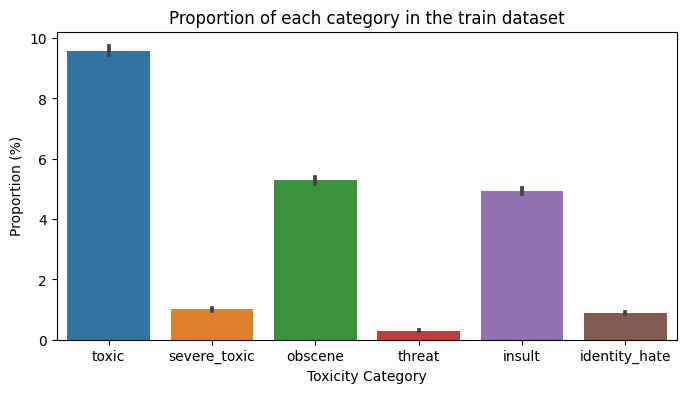

In [14]:
# Visualizing the proportion of each category in the train dataset
plt.figure(figsize=(8,4))
sns.barplot(100*data)
plt.title("Proportion of each category in the train dataset")
plt.ylabel("Proportion (%)")
plt.xlabel("Toxicity Category")
plt.show()

### Cleaning the Data

In [15]:
# Marking comments without any toxic category as "clean"
rowsums = data[label_cols].sum(axis=1)
data['clean'] = (rowsums == 0)

In [16]:
# Counting the number of clean entries
num_clean_comments = data['clean'].sum()

print("Total comments =", len(data))
print("Total clean comments =", num_clean_comments)

Total comments = 159571
Total clean comments = 143346


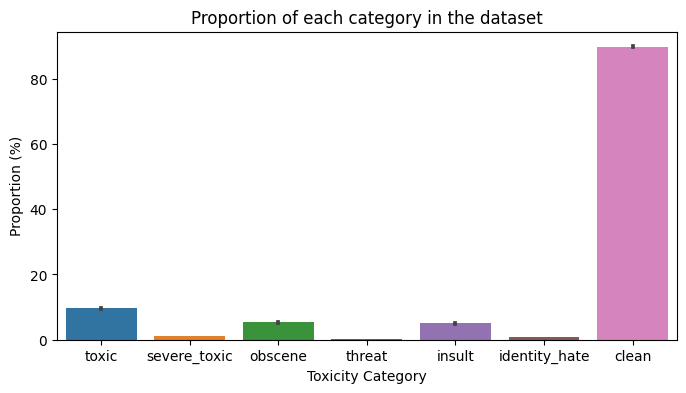

In [17]:
# Visualizing the proportion of each category in the dataset along side the proportion of clean data
plt.figure(figsize=(8,4))
sns.barplot(100*data)
plt.title("Proportion of each category in the dataset")
plt.ylabel("Proportion (%)")
plt.xlabel("Toxicity Category")
plt.show()

In [18]:
# Approximately 90% of the data in the dataset is clean and does not come under the category of toxicity.

In [19]:
# Counting the number of clean and toxic comments
clean_counts = data['clean'].value_counts()
clean_counts

True     143346
False     16225
Name: clean, dtype: int64

In [20]:
# Dropping excess clean records to balance the dataset
true_count = clean_counts[True]
false_count = clean_counts[False]

# Dropping the excess true values to balance the counts
excess_true_count = true_count - false_count
indices_to_drop = data[data['clean']].sample(excess_true_count).index
data = data.drop(indices_to_drop)

# Verifying the balanced counts
balanced_true_count = data['clean'].sum()
balanced_false_count = len(data) - balanced_true_count

print("Number of True values:", balanced_true_count)
print("Number of False values:", balanced_false_count)

Number of True values: 16225
Number of False values: 16225


In [21]:
# Count the number of true and false values
true_count = data['clean'].sum()
false_count = len(data) - true_count

print(true_count, false_count)

# Drop the excess true values to balance the counts
excess_true_count = true_count - false_count
indices_to_drop = data[data['clean']].sample(excess_true_count).index
data = data.drop(indices_to_drop)

# Verify the balanced counts
balanced_true_count = data['clean'].sum()
balanced_false_count = len(data) - balanced_true_count
print("Number of True values:", balanced_true_count)
print("Number of False values:", balanced_false_count)

16225 16225
Number of True values: 16225
Number of False values: 16225


In [22]:
# Checking the shape of the data we will be working with
data.shape

(32450, 8)

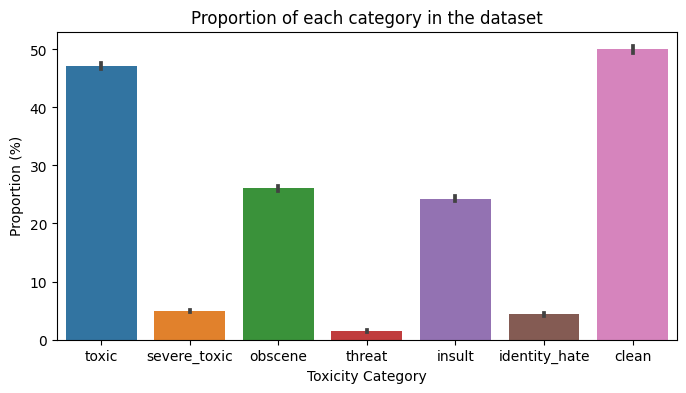

In [23]:
# Visualizing the proportion of each category in the dataset along side the proportion of clean data after dropping excess clean records
plt.figure(figsize=(8,4))
sns.barplot(100*data)
plt.title("Proportion of each category in the dataset")
plt.ylabel("Proportion (%)")
plt.xlabel("Toxicity Category")
plt.show()

In [24]:
# Generating the number of records for each toxic category
values = list(data[label_cols].sum())
values

[15294, 1595, 8449, 478, 7877, 1405]

### Pre-processing the Text Data

The below function called text_pre_processing performs text preprocessing operations on a given input comment. The function aims to clean and transform the text data to make it suitable for further analysis or natural language processing tasks. <br>The various steps of text preprocessing performed in the code block include:

* Converting the text to lowercase and resolving contractions using the contractions library.
* Replacing multiple newline characters with a single space and removing excess blank spaces using regular expressions.
* Removing punctuation marks from the text.
* Retaining only English letters and spaces while discarding other characters.
* Removing stopwords (commonly occurring words with little semantic meaning) using the stopwords module from the NLTK library.
<br><br>The processed comment is then returned as the output of the function.

These preprocessing steps help in cleaning and standardizing the text data, allowing for more accurate analysis, feature extraction, or modeling in natural language processing tasks.


In [25]:
# Function to pre-process the text
def text_pre_processing(comment):

  # Converting the data to lower case and resolving the contractions
  comment_lc = comment.lower()
  comment_lc = contractions.fix(comment_lc)
  # return comment_lc

  # Replacing multiple '\n' with a blank space and removing excess blank spaces
  pattern = '\s+'
  comment_lc = comment_lc.replace('\n', ' ')
  comment_lc = re.sub(pattern, ' ', comment_lc)
  # return comment_lc

  # Removing punctuations
  comment_lc_wo_punct = [x for x in comment_lc if x not in string.punctuation]
  comment_lc_wo_punct = ''.join(comment_lc_wo_punct)
  # return comment_lc_wo_punct

  # Keeping only English letters
  comment_wo_punct_only_words = [x for x in comment_lc_wo_punct if x.isalpha() or x == " "]
  comment_wo_punct_only_words = ''.join(comment_wo_punct_only_words)
  # return comment_wo_punct_only_words

  # Removing stopwords
  comment_wo_punct_only_words_lc = comment_wo_punct_only_words.split(" ")
  comment_wo_punct_only_words_lc_wo_sw = [x for x in comment_wo_punct_only_words_lc if x not in stopwords.words('english')]
  comment_wo_punct_only_words_lc_wo_sw = ' '.join(comment_wo_punct_only_words_lc_wo_sw)

  return comment_wo_punct_only_words_lc_wo_sw

### Stemming
"Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language."

Stem (root) is the part of the word to which you add inflectional (changing/deriving) affixes such as (-ed,-ize, -s,-de,mis). <br>So stemming a word or sentence may result in words that are not actual words.<br> Stems are created by removing the suffixes or prefixes used with a word.

In stemming, a computer algorithm often cuts off the ending or beginning of the word being analyzed.<br> The cut thus takes out prefixes and suffixes, which can lead to errors. Let’s take the words “studies” as an example.<br> A stemming algorithm would drop the suffix “es,” thus arriving at the root word “studi,” which we all know is not right. There’s no such word.

### Lemmatization
Lemmatization, reduces the inflected words properly ensuring that the root word belongs to the language.<br> In Lemmatization root word is called Lemma.<br> A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.<br> Because lemmatization returns an actual word of the language, it is used where it is necessary to get valid words.

Lemmatization, lets a word like “studies” undergo a morphological analysis based on a dictionary that the algorithm can consult to produce the correct root word.<br> As such, a lemmatization-capable machine would know that “studies” is the singular verb form of the word “study” in the present tense.

<div>
<img src = 'https://miro.medium.com/max/1400/1*ES5bt7IoInIq2YioQp2zcQ.png' width=500>
</div>

[Source](https://medium.com/geekculture/introduction-to-stemming-and-lemmatization-nlp-3b7617d84e65)

In [26]:
# Function to process the comments using Stemming and Lemmatizing
def stemming_and_lemmatizing(comment):

  # Stemming
  stemmer = PorterStemmer()
  # Function to perform stemming on a given text
  processed_stemming_comment = ([stemmer.stem(word) for word in nltk.word_tokenize(comment)])
  processed_stemming_comment = ' '.join(processed_stemming_comment)

  # Lemmatization
  # Create an instance of the WordNetLemmatizer
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = ([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(comment)])
  lemmatized_words = ' '.join(lemmatized_words)

  return processed_stemming_comment, lemmatized_words

In [27]:
# Testing transformation on the first 25 records
transformation_check = data[['comment_text']][0:25].copy()

transformation_check['preprocessed_comment'] = transformation_check['comment_text'].apply(text_pre_processing)
transformation_check['processed_stemming_comment'], transformation_check['lemmatized_words'] = zip(*transformation_check['preprocessed_comment'].apply(stemming_and_lemmatizing))
transformation_check.head(10)

,comment_text,preprocessed_comment,processed_stemming_comment,lemmatized_words
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker piss around work,cocksuck piss around work,cocksucker piss around work
12,Hey... what is it..\n@ | talk .\nWhat is it......,hey talk exclusive group wp talibanswho goo...,hey talk exclus group wp talibanswho good dest...,hey talk exclusive group wp talibanswho good d...
16,"Bye! \n\nDon't look, come or think of comming ...",bye look come think comming back tosser,bye look come think com back tosser,bye look come think comming back tosser
33,I was able to post the above list so quickly b...,able post list quickly already text file hard ...,abl post list quickli alreadi text file hard d...,able post list quickly already text file hard ...
42,You are gay or antisemmitian? \n\nArchangel WH...,gay antisemmitian archangel white tiger meow g...,gay antisemmitian archangel white tiger meow g...,gay antisemmitian archangel white tiger meow g...
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",fuck filthy mother ass dry,fuck filthi mother ass dri,fuck filthy mother as dry
44,I'm Sorry \n\nI'm sorry I screwed around with ...,sorry sorry screwed around someone talk page b...,sorri sorri screw around someon talk page bad ...,sorry sorry screwed around someone talk page b...
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,get fucked get fuckeeed got drink cannot put g...,get fuck get fuckee got drink can not put get ...,get fucked get fuckeeed got drink can not put ...
55,Stupid peace of shit stop deleting my stuff as...,stupid peace shit stop deleting stuff asshole ...,stupid peac shit stop delet stuff asshol go di...,stupid peace shit stop deleting stuff asshole ...
56,=Tony Sidaway is obviously a fistfuckee. He lo...,tony sidaway obviously fistfuckee loves arm ass,toni sidaway obvious fistfucke love arm ass,tony sidaway obviously fistfuckee love arm as


In [28]:
# Applying text preprocessing to the entire dataset
data['preprocessed_comment'] = data['comment_text'].apply(text_pre_processing)

In [29]:
# Applying stemming and lemmatization to the entire dataset
data['processed_stemming_comment'], data['processed_lemmatized_words'] = zip(*data['preprocessed_comment'].apply(stemming_and_lemmatizing))
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,preprocessed_comment,processed_stemming_comment,processed_lemmatized_words
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False,cocksucker piss around work,cocksuck piss around work,cocksucker piss around work
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,False,hey talk exclusive group wp talibanswho goo...,hey talk exclus group wp talibanswho good dest...,hey talk exclusive group wp talibanswho good d...
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,False,bye look come think comming back tosser,bye look come think com back tosser,bye look come think comming back tosser
33,I was able to post the above list so quickly b...,0,0,0,0,0,0,True,able post list quickly already text file hard ...,abl post list quickli alreadi text file hard d...,able post list quickly already text file hard ...
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,False,gay antisemmitian archangel white tiger meow g...,gay antisemmitian archangel white tiger meow g...,gay antisemmitian archangel white tiger meow g...


The `processed_stemming_comment` refers to the text data that has undergone stemming using a stemming algorithm. Stemming reduces words to their base or root form by removing suffixes or prefixes. However, in this context, it is mentioned that the generated words after stemming are not relevant. It implies that the stemmed words may not accurately represent the original meaning or context of the text.

Hence, to address this issue, I will use the `preprocessed_comment` and `processed_lemmatized_words` for further model training.

The `preprocessed_comment` refers to the text data that has undergone preprocessing steps, such as converting to lowercase, removing punctuation, and removing stopwords. These preprocessing steps aim to clean the text and remove unnecessary noise, allowing the model to focus on the essential content of the comment.

On the other hand, `processed_lemmatized_words` is the the text data that has undergone lemmatization. Lemmatization, unlike stemming, aims to reduce words to their base form based on their dictionary meaning. This approach considers the context and meaning of the word, resulting in more meaningful and relevant representations.

By using `preprocessed_comment` and `processed_lemmatized_words` instead of `processed_stemming_comment`, it is expected that the model will have access to more relevant and meaningful words, which can potentially improve the performance and accuracy of the model during training and classification task.

In [30]:
# Looking at the shape of the data
data.shape

(32450, 11)

In [31]:
# path = '/content/drive/My Drive/Colab Notebooks/Sikka.ai/processed_train.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   data.to_csv(f)

### Feature Engineering

### Count Vectorizer :
CountVectorizer converts a collection of text documents into a numerical representation that machine learning algorithms can understand. It represents each document as a vector of word counts, enabling further analysis and modeling tasks.

In [41]:
# Extracting features using Count vectorization
vectorizer = CountVectorizer()
vectorizer_nl = CountVectorizer()

X = vectorizer.fit_transform(data['processed_lemmatized_words'])
X_noLemma = vectorizer_nl.fit_transform(data['preprocessed_comment'])

y = data[label_cols].values

In [42]:
# Splitting the data into train and test sets using X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Splitting the data into train and test sets using X_notLemma
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_noLemma, y, test_size=0.2)

### Model Training

In [43]:
# Using GridSearchCV for the hyperparameters of the Random Forest Classifier (n_estimators, max_depth, min_samples_split, min_samples_leaf).
# Here, we are creating an instance of the Random Forest Classifier and using GridSearchCV to perform the grid search with 5-fold cross-validation

# Defining the parameter grid
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creating the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}
Best Score: 0.5337138973101931


In [44]:
# Model training using X_noLemma data

# Creating the Random Forest Classifier
rf_classifier_nl = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search_nl = GridSearchCV(estimator=rf_classifier_nl, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_nl.fit(X_train_nl, y_train_nl)

# Print the best parameters and best score
print("Best Parameters:", grid_search_nl.best_params_)
print("Best Score:", grid_search_nl.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
Best Score: 0.5285439137134051


In [45]:
# Training a Random Forest Classifier

model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [46]:
# Training a Random Forest Classifier using n_estimators as 100

model_nl = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model_nl.fit(X_train_nl, y_train_nl)

RandomForestClassifier(n_jobs=-1)

### Model Evaluation

In [47]:
# Evaluating the model and calculating the Accuracy score
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6425489954394182


In [48]:
# Evaluating the model with X_noLemma data and calculating the Accuracy score
y_pred_nl = model_nl.predict(X_test_nl)

# Accuracy
accuracy_nl = accuracy_score(y_test_nl, y_pred_nl)
print('Accuracy:', accuracy_nl)

Accuracy: 0.628351309707242


Since, the model with Lemmatized data = "model" performed almost same in terms of accuracy, I'll be using it for further evaluation

In [49]:
# Making predictions on a new text
text = 'I will kill you'
input_text = vectorizer.transform([text])
result = model.predict(input_text)
print(result)

predicted_labels = result[0]
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Display the predicted labels for the toxic categories
for i in range(len(class_names)):
    if predicted_labels[i] == 1:
        print('The input text is: ', class_names[i])

[[1 0 0 1 0 0]]
The input text is:  toxic
The input text is:  threat


In [50]:
# Calculating the multilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, y_pred)

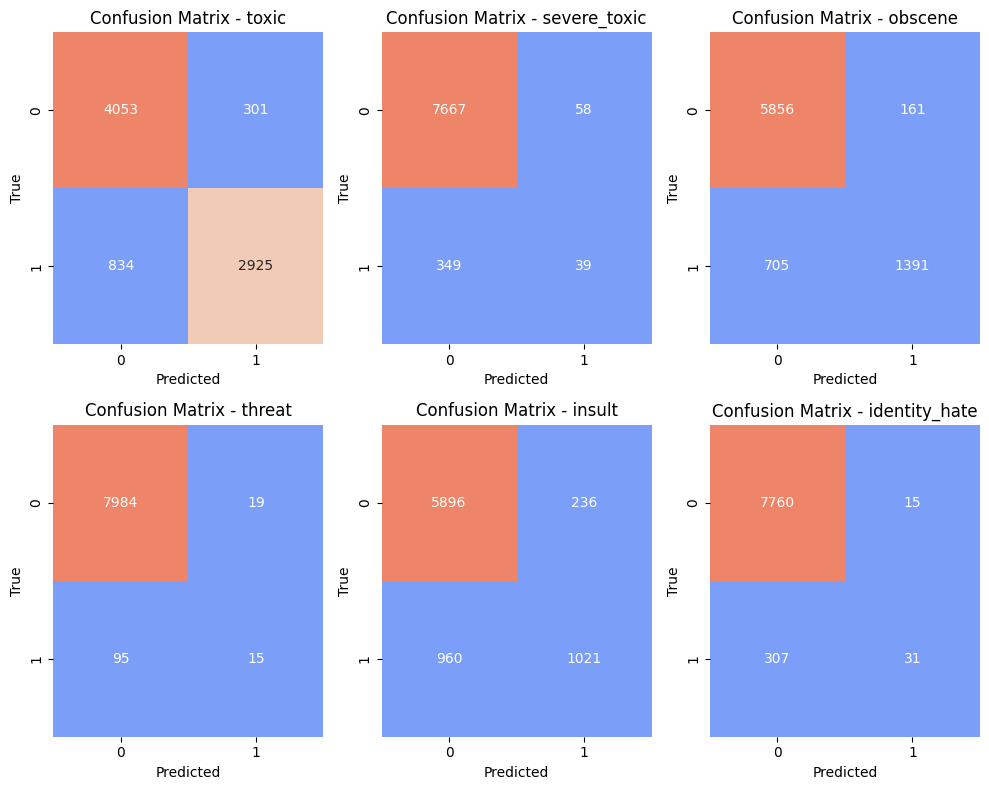

In [51]:
# Define class labels
class_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Define custom color map
cmap = sns.color_palette("coolwarm", 4)  # Adjust the number of colors as needed

# Plotting the multilabel confusion matrix
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm[i], annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title('Confusion Matrix - ' + class_labels[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

This above diagram is useful for visualizing the multilabel confusion matrix, which provides insights into the performance of a multilabel classification model by showing the true positives, true negatives, false positives, and false negatives for each toxic category we have in our dataset.

In [52]:
# Calculating the F1 score
f1score = f1_score(y_test, y_pred, average='micro')
print('F1 Score:', f1score)

F1 Score: 0.7285675893576996


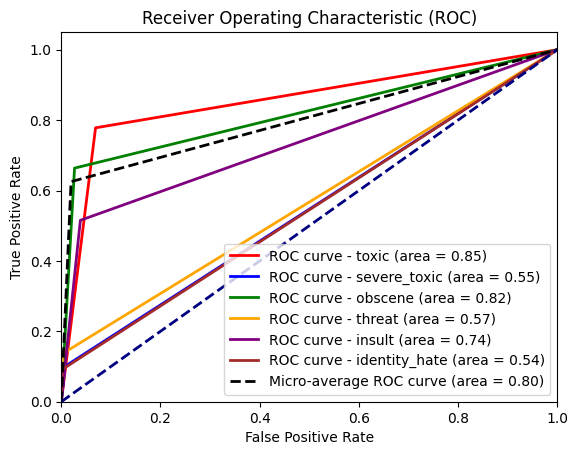

In [53]:
# ROC-AUC Curve

# Converting NumPy arrays to pandas DataFrames
y_test_df = pd.DataFrame(y_test, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
y_pred_df = pd.DataFrame(y_pred, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

# ROC-AUC Curve
n_classes = 6
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_df.iloc[:, i], y_pred_df.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Computing micro-average ROC curve and ROC-AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_df.values.ravel(), y_pred_df.values.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Define class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Plotting the ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    #plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve - Class %d (area = %0.2f)' % (i, roc_auc[i]))
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve - %s (area = %0.2f)' % (class_names[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='black', lw=lw, linestyle='--', label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Class "toxic" Area = 0.86: This means that for the ROC curve of "toxic" category, the area under the curve is 0.86. This indicates that the model's performance in distinguishing "toxic" instances from other category instances is relatively good. An AUC of 0.86 suggests a high true positive rate and a relatively low false positive rate for "toxic" category.

Class 2 Area = 0.53: For the ROC curve of "severe_toxic", the area under the curve is 0.53. This indicates that the model's ability to differentiate "severe_toxic" instances from "toxic" instances is relatively poor. An AUC of 0.53 suggests that the model's predictions for "severe_toxic" are not much better than random guessing.

Micro-Average ROC Curve Area = 0.80: The micro-average ROC curve area represents the overall performance of the model across all 6 toxic categories. In this case, the micro-average AUC is 0.80. It combines the performance of all categories, considering the total true positives, false positives, and false negatives across all classes. An AUC of 0.80 suggests that the model performs reasonably well in classifying instances overall.

A higher AUC indicates better classification performance, with 1 being the best and 0.5 indicating a random classifier. Therefore, an AUC of 0.86 for "toxic" and 0.80 for the micro-average suggests that the model has good discriminatory power for "toxic" but may struggle with "severe_toxic".

In [54]:
# Print the classification report
target_names = class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

               precision    recall  f1-score   support

        toxic       0.91      0.78      0.84      3759
 severe_toxic       0.40      0.10      0.16       388
      obscene       0.90      0.66      0.76      2096
       threat       0.44      0.14      0.21       110
       insult       0.81      0.52      0.63      1981
identity_hate       0.67      0.09      0.16       338

    micro avg       0.87      0.63      0.73      8672
    macro avg       0.69      0.38      0.46      8672
 weighted avg       0.85      0.63      0.71      8672
  samples avg       0.34      0.29      0.30      8672



The above classification report shows the performance of a machine learning model on a classification task - to classify comments as one of six classes: toxic, severe_toxic, obscene, threat, insult, or identity_hate.

The report shows the following metrics for each class:<br>

Precision: The percentage of predictions that were correct for that class.
Recall: The percentage of actual instances of that class that were correctly predicted.<br>
F1-score: A weighted harmonic mean of precision and recall.<br>
Support: The number of instances of that class in the dataset.<br>
The micro average metrics are calculated by considering all classes together. The macro average metrics are calculated by considering each class separately and then averaging the results. The weighted average metrics are calculated by considering each class separately and then weighting the results according to the support of each class.

The samples average metrics are calculated by considering each prediction separately and then averaging the results.

In this case, the model has a high micro average precision and recall, which means that it is generally good at predicting whether a comment is toxic or not. <br>However, the macro average precision and recall are lower, which means that the model is not as good at predicting each class individually. This is likely because some classes, such as severe_toxic, are much rarer than others, such as toxic.

The weighted average precision and recall are higher than the macro average precision and recall, which means that the model is better at predicting the more common classes.

The samples average precision and recall are much lower than the other metrics, which means that the model is not very good at predicting individual comments. This is likely because the model is not very good at handling the noise in the data.

Overall, the model has a good overall performance, but it could be improved by better handling the noise in the data and by improving its ability to predict the rarer classes.